# Testicular + Cervical Protein Expression Analysis Notebook:

This work, performed by Greg Lee and Ryan Boekholder, aims to explore similarities and differences between cervical and testicular protein expression. All data comes from MDAnderson via TCGA. 

In [30]:
#Scientific Computing and Data Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats
from scipy.linalg import svd

#Image Import Commands: 
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

In [31]:
#Colormap for Rasterized Plotting: Credit - Kendal
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='test',colors = ['red','black','green'])

In [32]:
#Data Path: Edit to rerun this notebook on a different device. 
folder_testicular = "./testicular_cancer/"
proteint_annot_testicular = "./metadata/testicular/mdanderson.org_TGCT.MDA_RPPA_Core.antibody_annotation.txt"
TCGA_annot_testicular = "./metadata/testicular/mdanderson.org_TGCT.MDA_RPPA_Core.sdrf.txt"
image_path = "./TCGA_Labels.png"
patient_info_testicular = "./metadata/testicular/nationwidechildrens.org_clinical_patient_tgct.txt"

folder_cervical = "./cervical_cancer/"
proteint_annot_cervical = "./metadata/cervical/mdanderson.org_CESC.MDA_RPPA_Core.antibody_annotation.txt"
TCGA_annot_cervical = "./metadata/cervical/mdanderson.org_CESC.MDA_RPPA_Core.sdrf.txt"
patient_info_cervical = "./metadata/cervical/nationwidechildrens.org_clinical_patient_cesc.txt"

## Data Exploration & Organization: Testicular Cancer

In [33]:
#How much patient data do we have? 
folder = folder_testicular
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} Files".format(len(onlyfiles)))

Working with 123 Files


In [34]:
#What comes in each file? It seems the protein and expression are annotated in files from MDAnderson
data = pd.read_csv(folder + onlyfiles[1], sep="\t",header=None)
data.columns = ["Protein", "Protein_Expression"]
data.head()

,Protein,Protein_Expression
0,Sample REF,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF
1,Composite Element REF,Protein Expression
2,14-3-3_beta-R-V,-0.0335156857500001
3,14-3-3_epsilon-M-C,0.09775616625
4,14-3-3_zeta-R-V,0.13591790775


In [35]:
#Importing Data to framework:
counter = 0
for names in onlyfiles: 
    if names == '.DS_Store':
        print("Skipping Files which are not Data")
    else: 
        new_data = pd.read_csv(folder + names, sep="\t",header=None)
        new_data.columns = ["Protein", "Protein_Expression"]
        data= data.merge(new_data,left_on='Protein',right_on="Protein")
    counter = counter +1   

print("The shape of the Testicular data frame is: " + str(data.shape))

#Drop the Composite Element REF and Transpose the data so Patients are on the Y axis with Proteins on X
data = data.drop(1,axis=0)
data = data.T

Skipping Files which are not Data
The shape of the Testicular data frame is: (220, 124)


In [36]:
#Merging the Proteins with the Gene Names (this is a source of bias!)
protein_annotations = pd.read_csv(proteint_annot_testicular, sep="\t",header=None)
protein_annotations = protein_annotations.drop(protein_annotations.columns[[1,3,4,5,6,7,8]],axis = 1)
protein_annotations = protein_annotations.T
protein_annotations.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C


In [37]:
#Adding the Gene Names to existing protein expression data
data_with_genes =  pd.merge(protein_annotations.T, data.T, left_on=2, right_on='Protein')
data_with_genes = data_with_genes.T
data_with_genes = data_with_genes.drop("Protein", axis=0)
data_with_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025
Protein_Expression_y,3A6A2C20-768D-44A6-9A60-8E06B938C7DD,0.07353710625,-0.0102309167499999,0.00777842375000004,-0.03335799075,0.10784540625,0.42195591525,0.18469539025,-0.39719495725,-0.0702879402499999,...,0.08875102275,-0.40576595925,0.20232167925,0.16949194925,-0.02762927475,-0.08810751125,-0.58564213825,0.41443317775,0.50069445975,0.19707753125
Protein_Expression_x,9509378B-1D46-4CA4-9FAB-A2B8B2A1D9BF,-0.0335156857500001,0.09775616625,0.13591790775,0.10521185625,0.11977563325,0.20885766125,0.14499582325,-0.51509615625,-0.07348159025,...,-0.04129273125,0.09013454175,0.43053252025,-0.0217619737500001,-0.0225894157500001,0.16182274875,0.22277084975,-0.25344510325,-0.0777456592500002,0.04896485025


In [38]:
#Import and merge the TCGA Barcodes to the Data: 
TCGA_Annot = pd.read_csv(TCGA_annot_testicular,sep="\t",header=None)
TCGA_Annot = TCGA_Annot[[4,9]]
data_genes_TCGA =  pd.merge(data_with_genes,TCGA_Annot , left_on=0, right_on=4,how='left')
data_genes_TCGA = data_genes_TCGA.drop_duplicates()

In [39]:
#Get all column names
cols = list(data_genes_TCGA)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('9_y')))
# use ix to reorder
data_genes_TCGA = data_genes_TCGA.loc[:, cols]
data_genes_TCGA = data_genes_TCGA.drop("4_y", axis=1)

In [40]:
#Final Reorganization Steps
data_genes_TCGA = data_genes_TCGA.reset_index()
data_genes_TCGA = data_genes_TCGA.drop(data_genes_TCGA.columns[[0]],axis = 1)
data_genes_TCGA.columns = range(data_genes_TCGA.shape[1])
data_genes_TCGA.shape

(124, 220)

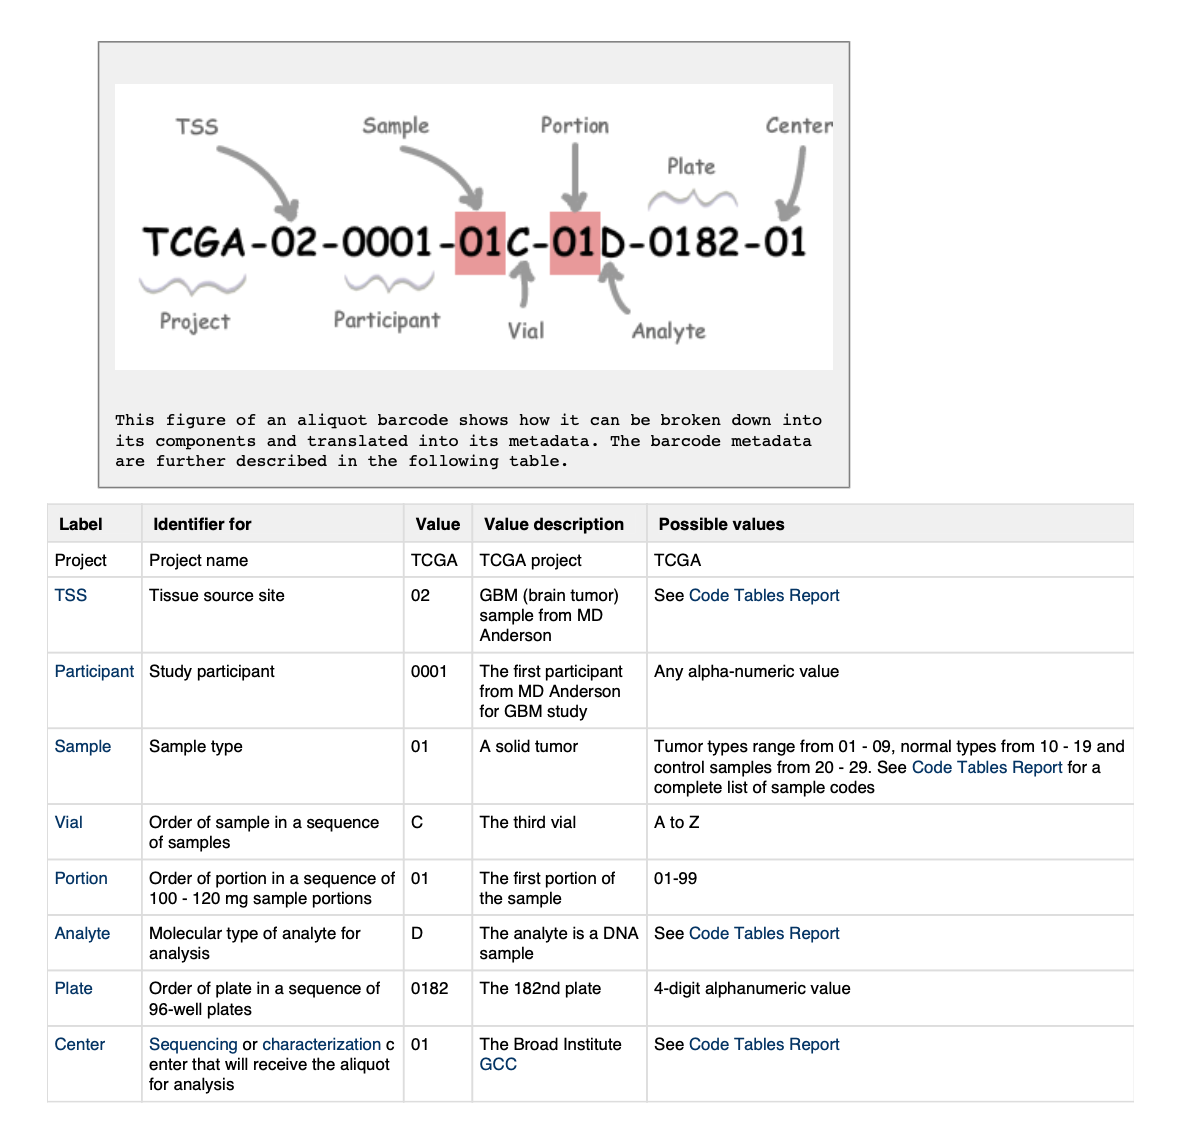

In [41]:
#The TCGA ID anatomy: 
from IPython.display import Image
Image(image_path)

In [42]:
#Pull out the Patient ID's from the rest of the annotation
data_genes_TCGA["PatientID_1"]= data_genes_TCGA.insert(0,'Patient_ID',data_genes_TCGA[0].astype(str).str[0:12])
data_genes_TCGA = data_genes_TCGA.drop("PatientID_1",axis=1)

In [43]:
#Adding the Patient Metadata based upon TCGA patient data
Patient_Info = pd.read_csv(patient_info_testicular,sep="\t",header=None)
Patient_Info = Patient_Info [[1,5,6,22,23,46,47,70,76,87]] #This is choosing the features to add from the metadata. Change if needed.
Patient_Info = Patient_Info.drop([0,1,2],axis=0)
Patient_Info.head()

#Below is are the features being kept:
#Patient ID, Race, Ethnicity, Tumor Status, Vital Status, AJCC Nodes Pathologic pn, AJCC Tumor Pathologic Pt
#,age at diagnosis, Gender,Tissue source site

,1,5,6,22,23,46,47,70,76,87
3,TCGA-2G-AAEW,WHITE,NOT HISPANIC OR LATINO,WITH TUMOR,Dead,N0,M0,31,MALE,Testes
4,TCGA-2G-AAEX,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,38,MALE,Testes
5,TCGA-2G-AAF1,ASIAN,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes
6,TCGA-2G-AAF4,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,30,MALE,Testes
7,TCGA-2G-AAF6,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes


In [44]:
#Merging and reindexing the patient information
data_genes_TCGA_patient =  pd.merge(Patient_Info, data_genes_TCGA, right_on="Patient_ID", left_on=1,how='right')
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([1],axis=1)

index = np.arange(start=0, stop=107, step=1)
index2 = [107,108]
index3 = np.arange(109,124,1)
indexi = np.concatenate((np.concatenate((index2, index)),index3))
data_genes_TCGA_patient = data_genes_TCGA_patient.reindex(indexi) 

data_genes_TCGA_patient = data_genes_TCGA_patient.reset_index()
data_genes_TCGA_patient.columns = range(data_genes_TCGA_patient.shape[1])

data_genes_TCGA_patient = data_genes_TCGA_patient.drop([0,1],axis=1)
testicular_cancer_db = data_genes_TCGA_patient

In [45]:
#Drop all patients for which there is no metadata. Reduces Patient size to 108
testicular_cancer_db = testicular_cancer_db.drop(np.arange(109,124,1),axis=0)
testicular_cancer_db.head()

,2,3,4,5,6,7,8,9,10,11,...,222,223,224,225,226,227,228,229,230,231
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,WHITE,NOT HISPANIC OR LATINO,WITH TUMOR,Dead,N0,M0,31,MALE,Testes,TCGA-2G-AAEW,...,0.0800928317499999,-0.28908724425,-0.35243072675,-0.0580790527500001,-0.17769509775,-0.01040692825,0.27357020775,-0.30725466725,-0.27246927925,0.0516381562500001
3,WHITE,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,38,MALE,Testes,TCGA-2G-AAEX,...,0.0392209742500002,0.0070381522500001,-0.000397927250000096,0.10194073875,-0.10780766725,0.000397927250000069,0.20384876625,0.14295990525,-0.35432554075,-0.11833798825
4,ASIAN,NOT HISPANIC OR LATINO,TUMOR FREE,Alive,N0,M0,28,MALE,Testes,TCGA-2G-AAF1,...,-0.00837370124999992,9.20687500000072e-05,-0.17978097475,0.06084878825,0.01051641625,-0.04558900325,0.11982208375,-0.0116358882499998,-0.10584633625,0.25487037625


## Data Exploration & Organization: Cervical Cancer

In [46]:
#How much patient data do we have? 
folder = folder_cervical
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} Files".format(len(onlyfiles)))

Working with 173 Files


In [47]:
#Protein name and expression are annotated in files from MDAnderson
data = pd.read_csv(folder + onlyfiles[1], sep="\t",header=None)
data.columns = ["Protein", "Protein_Expression"]
data.head()

,Protein,Protein_Expression
0,Sample REF,9F4623A9-D7C2-4EB5-8CA9-6F0C67828AEB
1,Composite Element REF,Protein Expression
2,14-3-3_beta-R-V,-0.0961422259999999
3,14-3-3_epsilon-M-C,0.0479013300000001
4,14-3-3_zeta-R-V,0.169819278


In [48]:
#Importing Data to framework:
counter = 0
for names in onlyfiles: 
    if names == '.DS_Store':
        print("Skipping Files which are not Data")
    else: 
        new_data = pd.read_csv(folder + names, sep="\t",header=None)
        new_data.columns = ["Protein", "Protein_Expression"]
        data= data.merge(new_data,left_on='Protein',right_on="Protein")
    counter = counter +1   
print("The shape of the Cervical data frame is: " + str(data.shape))

#Drop the Composite Element REF and Transpose the data so Patients are on the Y axis with Proteins on X
data = data.drop(1,axis=0)
data = data.T

The shape of the Cervical data frame is: (221, 175)


In [49]:
#Merging the Proteins with the Gene Names (this is a source of bias!)
protein_annotations = pd.read_csv(proteint_annot_cervical, sep="\t",header=None)
protein_annotations = protein_annotations.drop(protein_annotations.columns[[1,3,4,5,6,7,8]],axis = 1)
protein_annotations = protein_annotations.T
protein_annotations.head()

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C


In [50]:
#Adding the Gene Names to existing protein expression data
data_with_genes =  pd.merge(protein_annotations.T, data.T, left_on=2, right_on='Protein')
data_with_genes = data_with_genes.T
data_with_genes = data_with_genes.drop("Protein", axis=0)
data_with_genes.head()

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,Gene Name,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
2,Sample REF,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
Protein_Expression_x,9F4623A9-D7C2-4EB5-8CA9-6F0C67828AEB,-0.0961422259999999,0.0479013300000001,0.169819278,-0.075831038,0.038788279,-1.127755122,-0.198689621,-0.092354134,-0.103611109,...,-0.00122411699999997,0.039628302,0.0490967589999999,0.110302646,0.0508761200000001,0.03616566,0.218577961,0.293310549,-0.136349382,-0.268227368
Protein_Expression_y,6F7ABE28-0E7B-48F7-9713-F18E9D295340,0.312821002,0.155283895,2.065443593,0.612668201,0.0691699790000002,-0.389325492,0.723970018,-1.320540808,-0.230530221,...,0.652668032,-1.151127237,0.664127639,1.091521267,0.624802454,1.010854939,-0.288773081,0.693003233,-0.554225848,-0.0282948159999998
Protein_Expression_x,9F4623A9-D7C2-4EB5-8CA9-6F0C67828AEB,-0.0961422259999999,0.0479013300000001,0.169819278,-0.075831038,0.038788279,-1.127755122,-0.198689621,-0.092354134,-0.103611109,...,-0.00122411699999997,0.039628302,0.0490967589999999,0.110302646,0.0508761200000001,0.03616566,0.218577961,0.293310549,-0.136349382,-0.268227368


In [51]:
#Import and merge the TCGA Barcodes to the Data: 
TCGA_Annot = pd.read_csv(TCGA_annot_cervical,sep="\t",header=None)
TCGA_Annot = TCGA_Annot[[4,9]]
data_genes_TCGA =  pd.merge(data_with_genes,TCGA_Annot , left_on=0, right_on=4,how='left')
data_genes_TCGA = data_genes_TCGA.drop_duplicates()

In [52]:
#Get all column names
cols = list(data_genes_TCGA)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('9_y')))
# use ix to reorder
data_genes_TCGA = data_genes_TCGA.loc[:, cols]
data_genes_TCGA = data_genes_TCGA.drop("4_y", axis=1)

In [53]:
#Final Reorganization Steps
data_genes_TCGA = data_genes_TCGA.reset_index()
data_genes_TCGA = data_genes_TCGA.drop(data_genes_TCGA.columns[[0]],axis = 1)
data_genes_TCGA.columns = range(data_genes_TCGA.shape[1])
data_genes_TCGA.shape

(175, 221)

In [54]:
#Pull out the Patient ID's from the rest of the annotation
data_genes_TCGA["PatientID_1"]= data_genes_TCGA.insert(0,'Patient_ID',data_genes_TCGA[0].astype(str).str[0:12])
data_genes_TCGA = data_genes_TCGA.drop("PatientID_1",axis=1)

In [55]:
#Adding the Patient Metadata based upon TCGA patient data
Patient_Info = pd.read_csv(patient_info_cervical,sep="\t",header=None) 
Patient_Info = Patient_Info [[1,6,10,14,25,52,63,67,84,143]]
Patient_Info = Patient_Info.drop([1,2],axis=0)
Patient_Info.head()

# Selecting: 
#gender,race, vital_status, tumor_status, age_at_diagnosis, tumor_grade, ajcc_nodes_pathologic_pn
#ajcc_tumor_pathologic_pt, tissue_source_site

,1,6,10,14,25,52,63,67,84,143
0,bcr_patient_barcode,gender,race,vital_status,tumor_status,age_at_diagnosis,tumor_grade,ajcc_nodes_pathologic_pn,ajcc_tumor_pathologic_pt,tissue_source_site
3,TCGA-2W-A8YY,FEMALE,WHITE,Alive,TUMOR FREE,51,G3,N0,T2a2,2W
4,TCGA-4J-AA1J,FEMALE,WHITE,Alive,TUMOR FREE,31,G3,N0,T1b2,4J
5,TCGA-BI-A0VR,FEMALE,WHITE,Alive,TUMOR FREE,53,G3,N1,T2b,BI
6,TCGA-BI-A0VS,FEMALE,WHITE,Alive,TUMOR FREE,48,G3,N0,T1b1,BI


In [58]:
#Merging and reindexing the patient information
data_genes_TCGA_patient =  pd.merge(Patient_Info, data_genes_TCGA, right_on="Patient_ID", left_on=1,how='right')
data_genes_TCGA_patient = data_genes_TCGA_patient.drop([1],axis=1)

index = np.arange(start=0, stop=173, step=1)
index2 = [173,174]
index3 = np.arange(174,175,1)
indexi = np.concatenate((np.concatenate((index2, index)),index3))
data_genes_TCGA_patient = data_genes_TCGA_patient.reindex(indexi)

data_genes_TCGA_patient = data_genes_TCGA_patient.reset_index()
data_genes_TCGA_patient.columns = range(data_genes_TCGA_patient.shape[1])

data_genes_TCGA_patient = data_genes_TCGA_patient.drop([0,1],axis=1)
cervical_cancer_db = data_genes_TCGA_patient
cervical_cancer_db = cervical_cancer_db.drop([175],axis=0)

## Perform SVD on Raw Data:  

In [59]:
#Select the expression values only: 
cerv_data = cervical_cancer_db.iloc[2:,12:]
tes_data = testicular_cancer_db.iloc[2:,12:]

#Convert to numpy array 
cerv_array = cerv_data.values
tes_array = tes_data.values

In [60]:
#Provide some data shape information
print("The shape of is " + str(cerv_array.shape))
print("Total number of cervical patients: " + str(cerv_array.shape[0]))
print("Total number of cervical features: " + str(cerv_array.shape[1]))

print()
print("The shape of is " + str(tes_array.shape))
print("Total number of testicular patients: " + str(tes_array.shape[0]))
print("Total number of testicular features: " + str(tes_array.shape[1]))

The shape of is (173, 219)
Total number of cervical patients: 173
Total number of cervical features: 219

The shape of is (107, 218)
Total number of testicular patients: 107
Total number of testicular features: 218


In [61]:
#Object Arrays are causing an issue. 
#This comes from the mixed data types from the pandas matrix
cerv_test = np.array(list(cerv_array[:, :]), dtype=np.float)
tes_test = np.array(list(tes_array[:, :]), dtype=np.float)

In [62]:
#Perform the SVD
U_cerv,sigma_cerv,VT_cerv = svd(cerv_test,full_matrices=False)
U_tes,sigma_tes,VT_tes = svd(tes_test,full_matrices=False)

In [63]:
#Check shapes of produces SVD decomposition
print("Shape of U cervical " + str(U_cerv.shape))
sigma_cerv = np.diag(sigma_cerv) 
print("Shape of Sigma cervical" + str(sigma_cerv.shape))
print("Shape of VT cervical" + str(VT_cerv.shape))

print("\nShape of U testicular " + str(U_tes.shape))
sigma_tes = np.diag(sigma_tes) 
print("Shape of Sigma testicular" + str(sigma_tes.shape))
print("Shape of VT testicular" + str(VT_tes.shape))


Shape of U cervical (173, 173)
Shape of Sigma cervical(173, 173)
Shape of VT cervical(173, 219)

Shape of U testicular (107, 107)
Shape of Sigma testicular(107, 107)
Shape of VT testicular(107, 218)


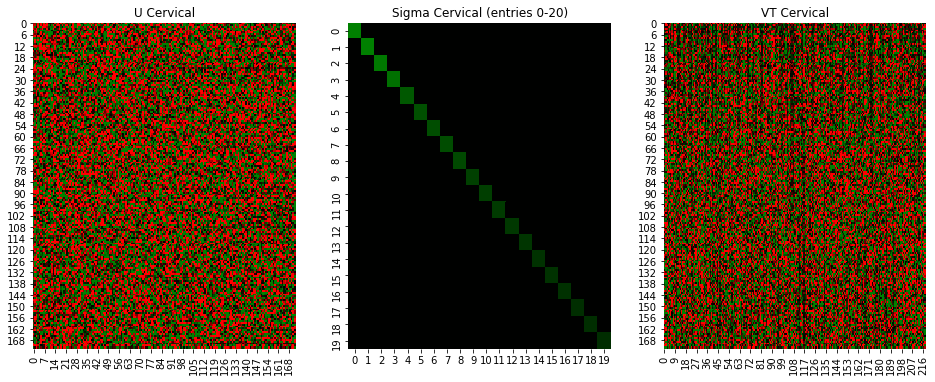

In [80]:
#Let's Visualize Heatmaps of Cervical SVD 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Cervical')
ax2.set_title('Sigma Cervical (entries 0-20)')
ax3.set_title('VT Cervical')
 
sns.heatmap(U_cerv, cmap=cmap, ax=ax1, cbar=False,vmin = -0.05,vmax = 0.05)
sns.heatmap(sigma_cerv[0:20,0:20], cmap=cmap, ax=ax2, cbar=False, center = 0,vmin = 0,vmax = 30)
sns.heatmap(VT_cerv, cmap=cmap, ax=ax3, cbar=False,vmin = -0.05,vmax = 0.05)

plt.show()

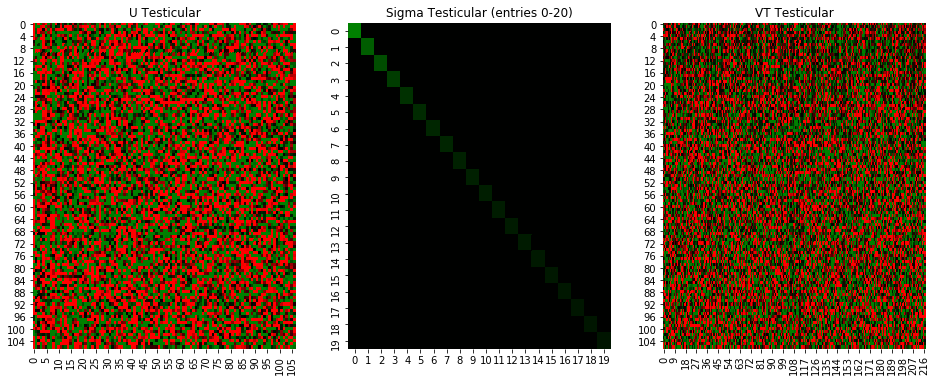

In [81]:
#Let's Visualize Heatmaps of testicular SVD decomposition
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Testicular')
ax2.set_title('Sigma Testicular (entries 0-20)')
ax3.set_title('VT Testicular')
 
sns.heatmap(U_tes, cmap=cmap, ax=ax1, cbar=False,vmin = -0.05,vmax = 0.05)
sns.heatmap(sigma_tes[0:20,0:20], cmap=cmap, ax=ax2, cbar=False, center = 0,vmin = 0,vmax = 30)
sns.heatmap(VT_tes, cmap=cmap, ax=ax3, cbar=False,vmin = -0.05,vmax = 0.05)

plt.show()

# Data Organization: Vital Status

In [82]:
#Sort: Vital Status  For testicular: C5 For cervical: C4
cerv_sort = cervical_cancer_db.sort_values(4)
test_sort = testicular_cancer_db.sort_values(5)

In [83]:
#Select the expression values only: 
cerv_sort = cerv_sort.iloc[:-2,12:]
tes_sort = test_sort.iloc[:-2,12:]

#Convert to numpy array 
cerv_sort_array = cerv_sort.values
tes_sort_array = tes_sort.values

#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
cerv_sort_array = np.array(list(cerv_sort_array[:, :]), dtype=np.float)
tes_sort_array = np.array(list(tes_sort_array[:, :]), dtype=np.float)

In [84]:
#Run the SVD

U_cerv,sigma_cerv,VT_cerv = svd(cerv_sort_array.T,full_matrices=False)
U_tes,sigma_tes,VT_tes = svd(tes_sort_array.T,full_matrices=False)

#Let's take a peep at this data
print("Shape of U cervical " + str(U_cerv.shape))
sigma_cerv = np.diag(sigma_cerv) 
print("Shape of Sigma cervical" + str(sigma_cerv.shape))
print("Shape of VT cervical" + str(VT_cerv.shape))

print("\nShape of U testicular " + str(U_tes.shape))
sigma_tes = np.diag(sigma_tes) 
print("Shape of Sigma testicular" + str(sigma_tes.shape))
print("Shape of VT testicular" + str(VT_tes.shape))

Shape of U cervical (219, 173)
Shape of Sigma cervical(173, 173)
Shape of VT cervical(173, 173)

Shape of U testicular (218, 107)
Shape of Sigma testicular(107, 107)
Shape of VT testicular(107, 107)


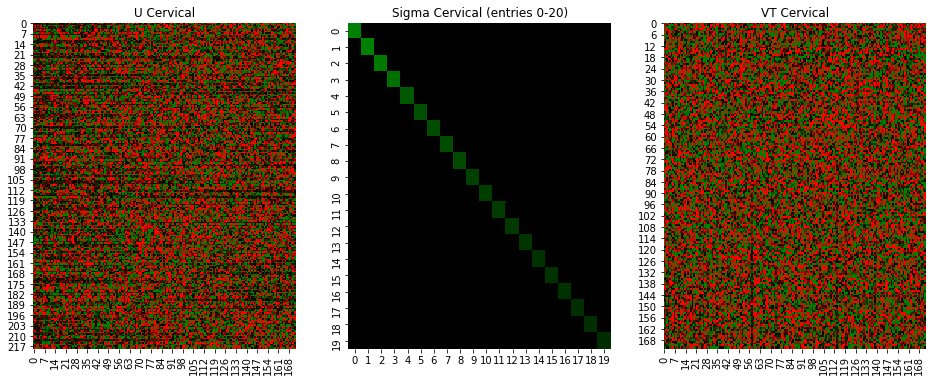

In [87]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Cervical')
ax2.set_title('Sigma Cervical (entries 0-20)')
ax3.set_title('VT Cervical')
 
sns.heatmap(U_cerv, cmap=cmap, ax=ax1, cbar=False,vmin = -0.05,vmax = 0.05)
sns.heatmap(sigma_cerv[0:20,0:20], cmap=cmap, ax=ax2, cbar=False, center = 0,vmin = 0,vmax = 30)
sns.heatmap(VT_cerv, cmap=cmap, ax=ax3, cbar=False,vmin = -0.05,vmax = 0.05)

plt.show()

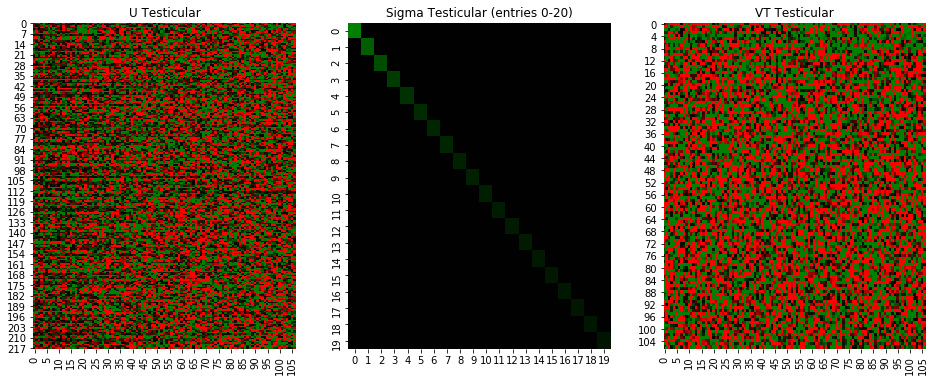

In [88]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Testicular')
ax2.set_title('Sigma Testicular (entries 0-20)')
ax3.set_title('VT Testicular')
 
sns.heatmap(U_tes, cmap=cmap, ax=ax1, cbar=False,vmin = -0.05,vmax = 0.05)
sns.heatmap(sigma_tes[0:20,0:20], cmap=cmap, ax=ax2, cbar=False, center = 0,vmin = 0,vmax = 30)
sns.heatmap(VT_tes, cmap=cmap, ax=ax3, cbar=False,vmin = -0.05,vmax = 0.05)

plt.show()

# Data Organization: Age

In [89]:
#Sort: Age of Diagnosis 
cerv_sort = cervical_cancer_db.sort_values(6)
test_sort = testicular_cancer_db.sort_values(8)

In [90]:
#Select the expression values only: 
cerv_sort = cerv_sort.iloc[:-2,12:]
tes_sort = test_sort.iloc[:-2,12:]

#Convert to numpy array 
cerv_sort_array = cerv_sort.values
tes_sort_array = tes_sort.values

#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
cerv_sort_age_array = np.array(list(cerv_sort_array[:, :]), dtype=np.float)
tes_sort_age_array = np.array(list(tes_sort_array[:, :]), dtype=np.float)


In [91]:
#Run the SVD
U_cerv_age,sigma_cerv_age,VT_cerv_age = svd(cerv_sort_age_array.T,full_matrices=False)
U_tes_age,sigma_tes_age,VT_tes_age = svd(tes_sort_age_array.T,full_matrices=False)

#Let's take a peep at this data
print("Shape of U cervical " + str(U_cerv_age.shape))
sigma_cerv_age = np.diag(sigma_cerv_age) 
print("Shape of Sigma cervical" + str(sigma_cerv_age.shape))
print("Shape of VT cervical" + str(VT_cerv_age.shape))

print("\nShape of U testicular " + str(U_tes_age.shape))
sigma_tes_age = np.diag(sigma_tes_age) 
print("Shape of Sigma testicular" + str(sigma_tes_age.shape))
print("Shape of VT testicular" + str(VT_tes_age.shape))

Shape of U cervical (219, 173)
Shape of Sigma cervical(173, 173)
Shape of VT cervical(173, 173)

Shape of U testicular (218, 107)
Shape of Sigma testicular(107, 107)
Shape of VT testicular(107, 107)


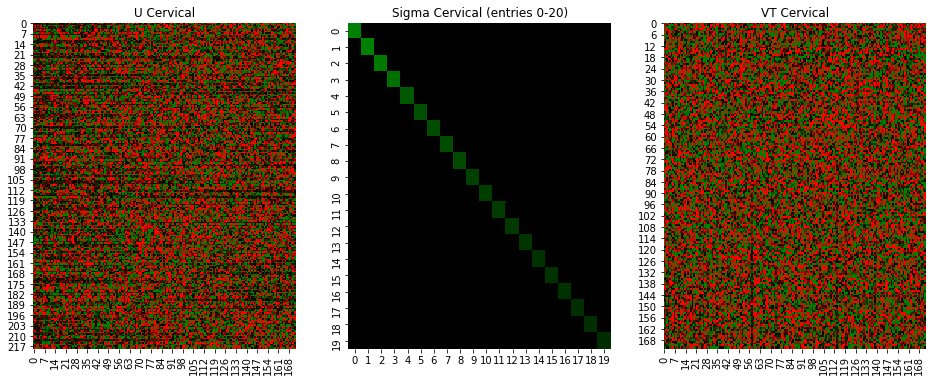

In [92]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Cervical')
ax2.set_title('Sigma Cervical (entries 0-20)')
ax3.set_title('VT Cervical')
 
sns.heatmap(U_cerv, cmap=cmap, ax=ax1, cbar=False,vmin = -0.05,vmax = 0.05)
sns.heatmap(sigma_cerv[0:20,0:20], cmap=cmap, ax=ax2, cbar=False, center = 0,vmin = 0,vmax = 30)
sns.heatmap(VT_cerv, cmap=cmap, ax=ax3, cbar=False,vmin = -0.05,vmax = 0.05)

plt.show()

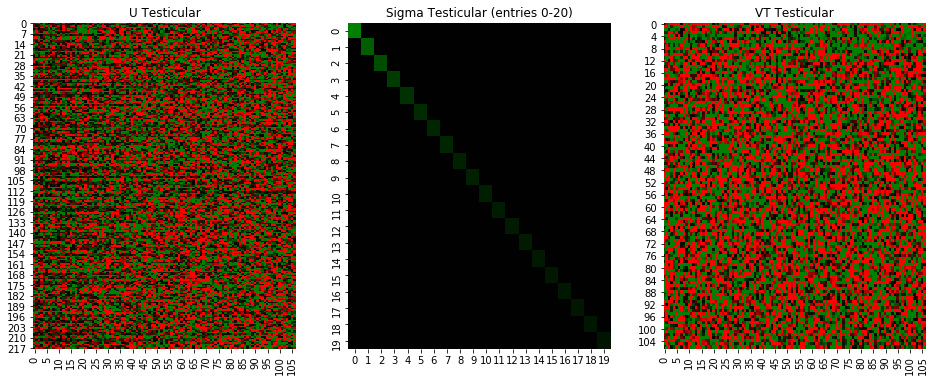

In [93]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Testicular')
ax2.set_title('Sigma Testicular (entries 0-20)')
ax3.set_title('VT Testicular')
 
sns.heatmap(U_tes, cmap=cmap, ax=ax1, cbar=False,vmin = -0.05,vmax = 0.05)
sns.heatmap(sigma_tes[0:20,0:20], cmap=cmap, ax=ax2, cbar=False, center = 0,vmin = 0,vmax = 30)
sns.heatmap(VT_tes, cmap=cmap, ax=ax3, cbar=False,vmin = -0.05,vmax = 0.05)

plt.show()

# Concatenate the testicular and cervical cancer dataframes based upon the proteins quantified (x = proteins, y = patients: cervical -> testicular)

In [94]:
cervical_cancer_db.iloc[0,49]
#Drop BRCA2 from Cervical (not included in testicular)
cervical_cancer_db_noBRCA2 = cervical_cancer_db.drop(51,axis=1) 

In [64]:
#Need Patient Features in the same order: 

#[CERVICAL] gender,race, vital_status, tumor_status, age_at_diagnosis, tumor_grade, ajcc_nodes_pathologic_pn
#ajcc_tumor_pathologic_pt, tissue_source_site

#[Testicular]#Race, Ethnicity, Tumor Status, Vital Status, AJCC Nodes Pathologic pn, AJCC Tumor Pathologic Pt
#,age at diagnosis, Gender,Tissue source site


In [95]:
#Alligning patient features: Order 
#Race, Tumor Status, Vital Status, AJCC Nodes Pathologic pn, AJCC Tumor Pathologic Pt
#,age at diagnosis, Gender,Tissue source site, Patient ID
cols = list(cervical_cancer_db_noBRCA2.columns.values)
cols = [3,5,4,8,9,6,2,10] + cols[9:]
cervical_cancer_db_noBRCA2 = cervical_cancer_db_noBRCA2.reindex(columns = cols)
testicular_cancer_db_BRCA2match = testicular_cancer_db.drop(3,axis = 1)

In [96]:
print("Cervical Cancer Data Shape: " + str(cervical_cancer_db_noBRCA2.shape))
print("Testicular Cancer Data Shape: " + str(testicular_cancer_db_BRCA2match.shape))
print("Where Patients rows and attributes then genes are columns")

Cervical Cancer Data Shape: (175, 229)
Testicular Cancer Data Shape: (109, 229)
Where Patients rows and attributes then genes are columns


In [98]:
#Reset the Index
cervical_cancer_db_noBRCA2 = cervical_cancer_db_noBRCA2.reset_index()
cervical_cancer_db_noBRCA2 = cervical_cancer_db_noBRCA2.drop(cervical_cancer_db_noBRCA2.columns[[0]],axis = 1)
cervical_cancer_db_noBRCA2.columns = range(cervical_cancer_db_noBRCA2.shape[1])

testicular_cancer_db_BRCA2match = testicular_cancer_db_BRCA2match.reset_index()
testicular_cancer_db_BRCA2match = testicular_cancer_db_BRCA2match.drop(testicular_cancer_db_BRCA2match.columns[[0]],axis = 1)
testicular_cancer_db_BRCA2match.columns = range(testicular_cancer_db_BRCA2match.shape[1])

In [99]:
#Concatenate!
comb_cerv_test = pd.concat([cervical_cancer_db_noBRCA2,testicular_cancer_db_BRCA2match.iloc[2:,:]], axis=0)
comb_cerv_test.shape

(282, 229)

In [100]:
#Reindex and Display Final Dataframe: 
comb_cerv_test = comb_cerv_test.reset_index()
comb_cerv_test = comb_cerv_test.drop(comb_cerv_test.columns[[0]],axis = 1)
comb_cerv_test.columns = range(comb_cerv_test.shape[1])
comb_cerv_test.head()

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C
2,WHITE,TUMOR FREE,Alive,N0,T2a2,51,FEMALE,2W,TCGA-2W-A8YY,TCGA-2W-A8YY-01A-21-A40H-20.P,...,0.838128249,-1.204358576,0.98026583,0.576061552,0.742962649,0.280943847,-0.427620815,-1.555734871,-0.519747159,-0.0442280939999999
3,WHITE,TUMOR FREE,Alive,N0,T1b2,31,FEMALE,4J,TCGA-4J-AA1J,TCGA-4J-AA1J-01A-11-A40H-20.P,...,0.0805494759999999,-0.253046523,0.942242258,-0.114616487,0.016992148,-0.434624842,-0.144857264,0.507210703,-0.140891075,-0.499351567
4,BLACK OR AFRICAN AMERICAN,WITH TUMOR,Dead,N1,T1b,21,FEMALE,C5,TCGA-C5-A0TN,TCGA-C5-A0TN-01A-11-A40H-20.P,...,0.263113133,-0.733918136,0.745076229,0.0438304549999999,0.416370827,-0.130751658,-0.765478521,-0.140173625,-0.269787991,-0.582786817


In [101]:
#From 2-174 is Cervical patients while 175-282 are the Testicular patients
comb_cerv_test.iloc[173:177,0:9]

,0,1,2,3,4,5,6,7,8
173,WHITE,[Unknown],Alive,N1,T1b2,34,FEMALE,ZJ,TCGA-ZJ-AAXN
174,WHITE,[Unknown],Alive,N1,T2b,25,FEMALE,ZJ,TCGA-ZJ-AB0I
175,WHITE,WITH TUMOR,Dead,N0,M0,31,MALE,Testes,TCGA-2G-AAEW
176,WHITE,TUMOR FREE,Alive,N0,M0,38,MALE,Testes,TCGA-2G-AAEX


In [103]:
#We want to compare the protein expression of the two different cancers. Thus... we apply: 

#Select the expression values only: 
comb_cerv_test = comb_cerv_test.iloc[2:,11:]

#Convert to numpy array 
comb_cerv_test_array = comb_cerv_test.values

#Object Arrays are causing an issue. This comes from the mixed data types from the pandas matrix
comb_cerv_test_array = np.array(list(comb_cerv_test_array[:, :]), dtype=np.float)

In [104]:
#Run the SVD
U_comb,sigma_comb,VT_comb = svd(comb_cerv_test_array,full_matrices=False)

#Preview Data Frame Sizing
print("Shape of U cervical " + str(U_comb.shape))
sigma_comb = np.diag(sigma_comb) 
print("Shape of Sigma cervical" + str(sigma_comb.shape))
print("Shape of VT cervical" + str(VT_comb.shape))

print("we have 280 patients and 218 proteins")

Shape of U cervical (280, 218)
Shape of Sigma cervical(218, 218)
Shape of VT cervical(218, 218)
we have 280 patients and 218 proteins


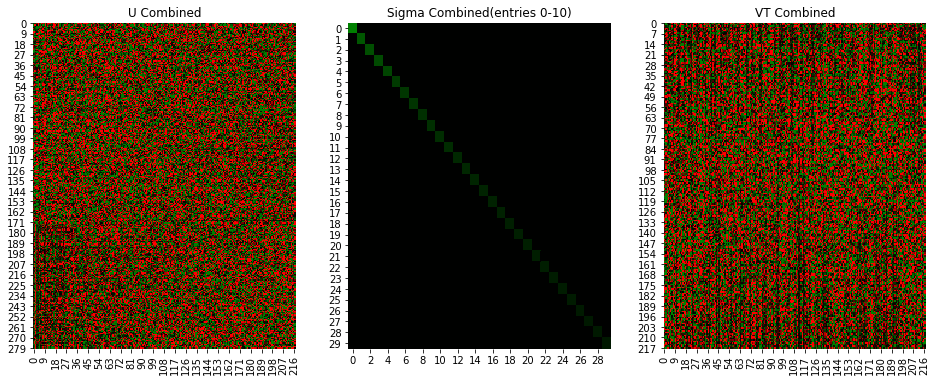

In [105]:
#Let's Visualize Heatmaps....
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('U Combined')
ax2.set_title('Sigma Combined(entries 0-30)')
ax3.set_title('VT Combined')
 
sns.heatmap(U_comb, cmap = cmap,vmin = -0.05,vmax = 0.05, ax=ax1, cbar=False)
sns.heatmap(sigma_comb[0:30,0:30], cmap = cmap, ax=ax2, cbar=False,center = 0)
sns.heatmap(VT_comb, cmap = cmap,vmin = -0.05,vmax = 0.05, ax=ax3, cbar=False)

plt.show()

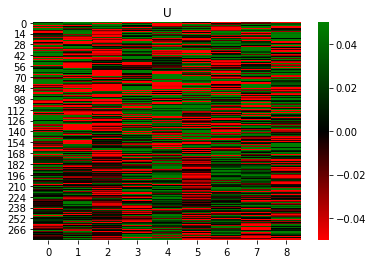

In [106]:
#Based upon experimentation: There exists significant difference in the columns of U below, between the rows of 
#cervical and the rows of testicular cancer. We choose to first examine columns 18 and 19 (eigen proteins)
#As their significance is highest. Previewed through #30. 

ax = sns.heatmap(U_comb[:,[6,9,10,13,17,18,19,20,24]],cmap = cmap,vmin = -0.05,vmax = 0.05)
plt.title("U for Significant Columns (eigenproteins)")
plt.show()

In [111]:
#Check the significance of columns and 18 and 19 by examining the weight of sigma: 
print("the value of sigma for trend 1: " + str(sigma_comb[18,18]))
print("the value of sigma for trend 2: " + str(sigma_comb[19,19]))

print("\nUnsure of these values are too close to be uncomfy... Relatively close to values 17 and 20")

the value of sigma for trend 1: 11.901183949105901
the value of sigma for trend 2: 11.697201433913165
Unsure of these values are too close to be uncomfy... Relatively close to values 17 and 20


In [112]:
#Checking the Statistical Signifance between the Cervical and Testicular Cancers for columns 18 and 19 

#Trend 1
cerv_U_trend1  = U_comb[:172,18]
test_U_trend1 = U_comb[173:,18]
print(stats.mannwhitneyu(cerv_U_trend1,test_U_trend1))


#Trend 2 
cerv_U_trend2  = U_comb[:172,19]
test_U_trend2 = U_comb[173:,19]
print(stats.mannwhitneyu(cerv_U_trend2,test_U_trend2))

MannwhitneyuResult(statistic=6741.0, pvalue=8.676376326659021e-05)
MannwhitneyuResult(statistic=6666.0, pvalue=5.460065062675605e-05)


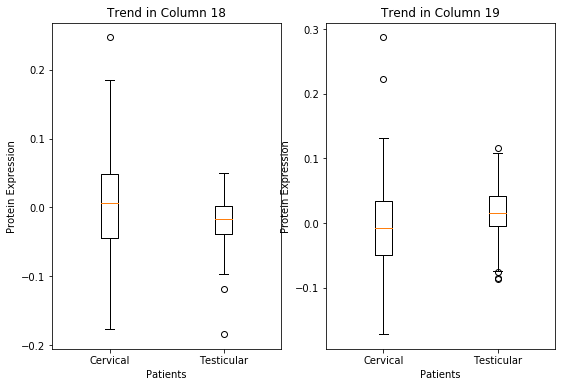

In [121]:
#Boxplots of the trends observed. X axis is Cervical and testicular
trend_1 = [cerv_U_trend1,test_U_trend1]
trend_2 = [cerv_U_trend2,test_U_trend2]

fig = plt.figure(1,(9,6))
ax = fig.add_subplot(121)
my_xticks = ['Cervical', 'Testicular']
ax.set_xlabel('Patients')
ax.set_ylabel('Protein Expression')
ax.set_xticklabels(my_xticks)
bp = ax.boxplot(trend_1)
plt.title("Trend in Column 18")




ax = fig.add_subplot(122)
bp = ax.boxplot(trend_2)
my_xticks = ['Cervical', 'Testicular']
ax.set_xlabel('Patients')
ax.set_ylabel('Protein Expression')
ax.set_xticklabels(my_xticks)
plt.title("Trend in Column 19")
plt.show()

# Take Columns 18, 19 and apply to VT to examine relevant protein patterns

In [79]:
VT_trend1 = VT_comb[18,:]
VT_trend2 = VT_comb[19,:]

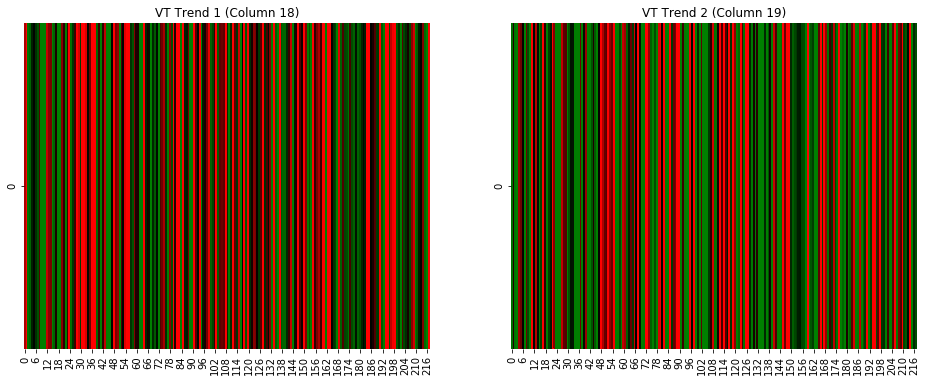

In [121]:
#Next let's visualize this row in V Transpose...
VT_trend1  = np.reshape(VT_comb[18,:],(VT_trend1.shape[0],1))
VT_trend2  = np.reshape(VT_comb[19,:],(VT_trend2.shape[0],1))

#Let's Visualize Heatmaps....
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(16, 6)
ax1.set_title('VT Trend 1 (Column 18)')
ax2.set_title('VT Trend 2 (Column 19)')

sns.heatmap(VT_trend1.T, cmap = cmap,vmin = -0.05,vmax = 0.05, ax=ax1, cbar=False)
sns.heatmap(VT_trend2.T, cmap = cmap, vmin = -0.05,vmax = 0.05, ax=ax2, cbar=False)

plt.show()

In [81]:
#Create a new dataframe which links the data back to it's initial labels
comb_cerv_protgene_label = pd.concat([cervical_cancer_db_noBRCA2,testicular_cancer_db_BRCA2match.iloc[2:,:]], axis=0)
comb_cerv_protgene_label = comb_cerv_protgene_label.drop([0,1,2,3,4,5,6,7,8,9,10],axis=1)
comb_cerv_protgene_label = comb_cerv_protgene_label.iloc[0:2,:]

,11,12,13,14,15,16,17,18,19,20,...,219,220,221,222,223,224,225,226,227,228
0,YWHAB,YWHAE,YWHAZ,EIF4EBP1,EIF4EBP1,EIF4EBP1,EIF4EBP1,TP53BP1,ARAF,ACACA ACACB,...,CHEK1,COG3,GUSP4,ERCC5,IGFR1,IRF1,JAK2,CDKN2A,PTPN11,CDK1
1,14-3-3_beta-R-V,14-3-3_epsilon-M-C,14-3-3_zeta-R-V,4E-BP1-R-V,4E-BP1_pS65-R-V,4E-BP1_pT37_T46-R-V,4E-BP1_pT70-R-V,53BP1-R-E,A-Raf_pS299-R-C,ACC_pS79-R-V,...,Chk1_pS296-R-V,COG3-R-V,DUSP4-R-V,ERCC5-R-C,IGF1R_pY1135_Y1136-R-V,IRF-1-R-C,Jak2-R-V,p16_INK4a-R-V,SHP-2_pY542-R-C,CDK1_pY15-R-C


In [82]:
#Recombine with VT data
trend_wgene = comb_cerv_protgene_label.T
trend_wgene['trend1'] = VT_trend1
trend_wgene['trend2'] = VT_trend2
trend_wgene = trend_wgene.reset_index(drop = True)
trend_wgene = trend_wgene.rename(columns={0: "Gene", 1: "Protein"})
#trend_wgene = trend_wgene.T
trend_wgene.head()

,Gene,Protein,trend1,trend2
0,YWHAB,14-3-3_beta-R-V,-0.033003,0.043438
1,YWHAE,14-3-3_epsilon-M-C,-0.055403,-0.006933
2,YWHAZ,14-3-3_zeta-R-V,0.045320,0.045445
3,EIF4EBP1,4E-BP1-R-V,0.038519,0.060724
4,EIF4EBP1,4E-BP1_pS65-R-V,0.011793,-0.030584


In [114]:
#Order these based upon the different trends from ascending to descending
sorted_trend_wgene = trend_wgene.sort_values(by=['trend2'], ascending=False)
sorted_trend_wgene = sorted_trend_wgene.reset_index(drop = True)
sorted_trend_wgene = sorted_trend_wgene.reset_index(drop = False)

sorted_trend_wgene.head()

,index,Gene,Protein,trend1,trend2
0,0,HSPA1A,HSP70-R-C,-0.097111,0.255863
1,1,CDKN1A,p21-R-V,0.016359,0.193397
2,2,KIT,c-Kit-R-V,-0.110994,0.177857
3,3,LCK,Lck-R-V,0.025895,0.170106
4,4,STAT5A,STAT5-alpha-R-V,0.038901,0.168587


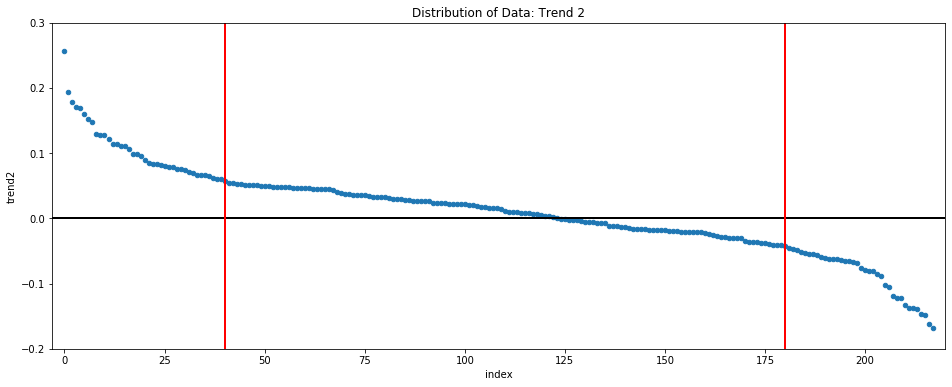

In [115]:
#Create a plot to establish reasonable cut-off areas
fig,(ax1) = plt.subplots(ncols=1,nrows=1)
fig.set_size_inches(16, 6)
sorted_trend_wgene.plot.scatter(x='index',y='trend2',ax=ax1)
ax1.set_title('Distribution of Data: Trend 2')
plt.autoscale(enable=True, tight=True)
plt.plot([-3, 220], [0, 0], 'k-', lw=2)
plt.plot([40, 40], [-0.2, 0.3], 'r', lw=2)
plt.plot([180, 180], [-0.2, 0.3], 'r', lw=2)

plt.show()

In [109]:
#Using Gorilla To Derive Conclusions: 
topgene = sorted_trend_wgene.iloc[0:40,[1]].to_numpy()
bottomgene = sorted_trend_wgene.iloc[-40:,[1]].to_numpy()

print("The Top Genes Are:  ")
for words in topgene:
    print(str(words).lstrip('[').rstrip(']').replace("\'", ""))

print("\nThe bottom genes are: \nFound no significance with under 50 Genes")
#for words in bottomgene:
    #print(str(words).lstrip('[').rstrip(']').replace("\'", ""))
    
    
print("Getting some significance for top genes with threshold set at 40 & Pvalue = 9.22e-04")
print("Reason: (+) regulation of protein kinase b")

The Top Genes Are:  
HSPA1A
CDKN1A
KIT
LCK
STAT5A
CLDN7
ARID1A
MAP2K1
ERBB3
PIK3R1 PIK3R2
CCND1
FN1
COL6A1
SERPINE1
CDKN2A
MAPK1 MAPK3
PRKAA1
CAV1
RPS6
ACACA
BAX
BID
ATM
BRAF
BRD4
XBP1
SYK
RPS6
GAPDH
RBM15
PARP1
TSC2
TP53BP1
MAPK9
MAP2K1
PRKCA 
IGFBP2
RPS6KA1
EIF4EBP1
MYC

The bottom genes are: 
Found no significance with under 50 Genes
Getting some significance for top genes with threshold set at 40 & Pvalue = 9.22e-04
Reason: (+) regulation of protein kinase b


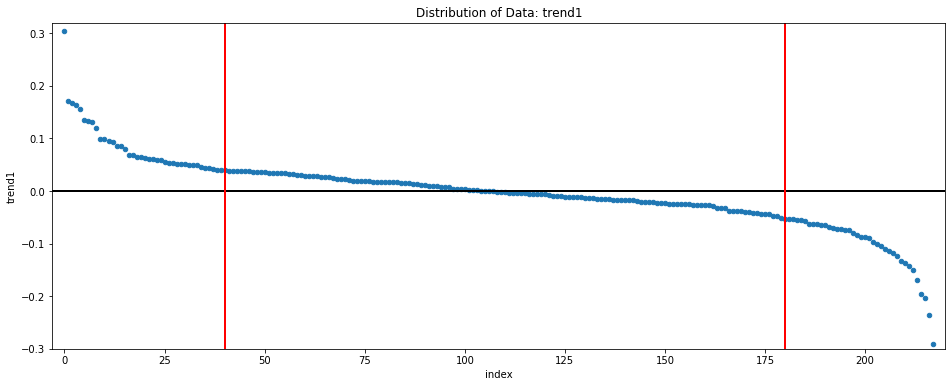

In [112]:
#Let's try the same with trend 19 and see what comes back....

#Sort based upon trend 1
sorted_trend_wgene = trend_wgene.sort_values(by=['trend1'], ascending=False)
sorted_trend_wgene = sorted_trend_wgene.reset_index(drop = True)
sorted_trend_wgene = sorted_trend_wgene.reset_index(drop = False)

sorted_trend_wgene.head()
fig,(ax1) = plt.subplots(ncols=1,nrows=1)
fig.set_size_inches(16, 6)
sorted_trend_wgene.plot.scatter(x='index',y='trend1',ax=ax1)
ax1.set_title('Distribution of Data: Trend1')
plt.autoscale(enable=True, tight=True)
plt.plot([-3, 220], [0, 0], 'k-', lw=2)
plt.plot([40, 40], [-0.3, 0.32], 'r', lw=2)
plt.plot([180, 180], [-0.3, 0.32], 'r', lw=2)

plt.show()

In [122]:
#Using Gorilla To Derive Conclusions: 
topgene = sorted_trend_wgene.iloc[0:40,[1]].to_numpy()
bottomgene = sorted_trend_wgene.iloc[-50:,[1]].to_numpy()

print("The Top Genes Are:  ")
#for words in topgene:
    #print(str(words).lstrip('[').rstrip(']').replace("\'", ""))

print("\nThe bottom genes are: \nFound no significance with under 50 Genes")
#for words in bottomgene:
    #print(str(words).lstrip('[').rstrip(']').replace("\'", ""))
    
    
print("Getting some significance for top genes with threshold set at 40 & Pvalue = 9.22e-04")
print("Reason: (+) regulation of protein kinase b")

print("Getting significance for bottom enes with threshold set at 60 for epigentic gene regulation w/ Pval = ")

The Top Genes Are:  

The bottom genes are: 
Found no significance with under 50 Genes
Getting some significance for top genes with threshold set at 40 & Pvalue = 9.22e-04
Reason: (+) regulation of protein kinase b
Getting significance for bottom enes with threshold set at 60 for epigentic gene regulation w/ Pval = 


In [ ]:
#So what does this mean? There are significant number of genes involved with regulation of protein kinase b 
#in both cancers.....?

# Analyzing ESR1 Levels in Testicular vs. Cervical cancers

In [ ]:
#ESR1 is Estrogen receptor 1. We would expect that expression would be (on average) higher for Cervical Cancer

#Approach: First find the location of the estrogen data.Place the data into an array. Then plot against the testicular d
#data in a boxplot

In [ ]:
testicular_cancer_db.iloc[0,84]

In [ ]:
ESR1_cervical_protein_level_U = cerv_sort_age_array[:,73]
ESR1_testicular_protein_level_U = tes_sort_age_array[:,72]
ESR1_Data = [ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U]\

ESR1_testicular_protein_level_U.max()

In [ ]:
fig = plt.figure(1,(9,6))
ax = fig.add_subplot(111)
bp = ax.boxplot(ESR1_Data)
plt.show()

In [ ]:
from scipy import stats
stats.ttest_ind(ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U)

# This shows there is significant difference in expression level of ESR1 between the two types of cancer.

In [ ]:
ESR1_cervical_protein_level_U = U_cerv_age[74,:]
ESR1_testicular_protein_level_U = U_tes_age[73,:]
ESR1_Data = [ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U]

In [ ]:
fig = plt.figure(1,(9,6))
ax = fig.add_subplot(111)
bp = ax.boxplot(ESR1_Data)


plt.xticks((1,2),('Cervical','Testicular'),color = 'k')
plt.ylabel("Protein Expression")
plt.title("ESR1 Protein Expression")

plt.show()

In [ ]:
from scipy import stats

stats.ttest_ind(ESR1_cervical_protein_level_U,ESR1_testicular_protein_level_U)

# This is me overthinking stufff

In [174]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn.britannica.com/18/66018-050-AA222E0F/Bruce-Lee-scene-Enter-the-Dragon-1973.jpg")